# to understand mineral ppte/dissolution first need to undertsand Ksp (equilib)

for the dissolution equilibrium reaction of a solid (AB$_{(s)}$)

$$ \mathrm{AB}_{(\mathrm{s})} = \mathrm{A^{n+}} + \mathrm{B^{n-}}$$

$$K_{sp} = [\mathrm{A^{n+}}][\mathrm{B^{n-}}]$$

we can solve for precipitation or not and the amount if we compare the ion activity product  (IAP) to the $K_{sp}$ value.  IF IAP is is greater than Ksp then preciptiation will happen until the two are equal (IAP is the same mathematical from as $K_{sp}$ but IAP is not necessarily at equilibrium.

Let's do an example with 10 mM calcium and open system and increasing the pH.

$$ \mathrm{CaCO_3}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + \mathrm{CO_3^{2-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{CO_3^{2-}}]=3.4e-9$$

ALSO for comparison calculate saturation index (IAP/$K_{sp}$) for portlandite.  If IAP>1 ppte would be predicted.

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2=5.5e-6$$


In [8]:
% clear the space

clear

% input constants

KspC=3.4e-9; KspP=5.5e-6; PCO2=10^-3.5; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; Kw=1e-14;
pH=2:0.1:14; H=10.^-pH; OH=Kw./H; CaT=0.01; Ca=CaT;

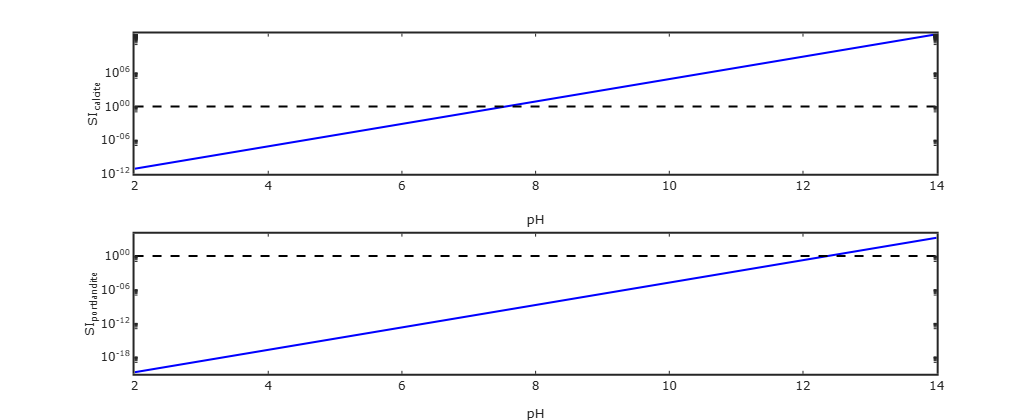

In [9]:
% run without allowing precipitation just to show what the SI looks like
graphics_toolkit ("plotly");

H2CO3=KH*PCO2*ones(size(pH)); HCO3=(Ka1.*H2CO3)./H; CO3=(Ka2.*HCO3)./H; 
IAPC=Ca.*CO3; SIC=IAPC./KspC; IAPP=Ca.*((OH).^2); SIP=IAPP./KspP;

subplot(211); semilogy(pH,SIC,'b-','linewidth',2); xlabel('pH'); ylabel('SI_{calcite}'); set(gca,'linewidth',2,'fontsize',12)
hold on; plot(pH,ones(size(pH)),'k--','linewidth',2)
yticks([10^-12 10^-6 10^0 10^6]); 

subplot(212); semilogy(pH,SIP,'b-','linewidth',2); xlabel('pH'); ylabel('SI_{portlandite}'); set(gca,'linewidth',2,'fontsize',12)
hold on; plot(pH,ones(size(pH)),'k--','linewidth',2)
yticks([10^-18 10^-12 10^-6 10^0]); 


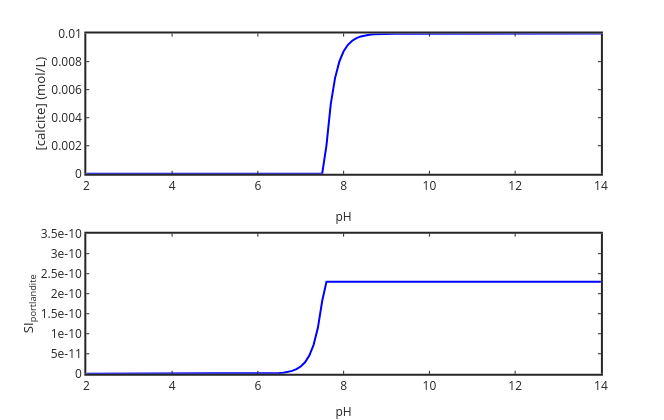

In [10]:
% now if SI>=1 ppte CaCO3

Ca=CaT*ones(size(pH)); Calcite=zeros(size(pH));

for i=1:length(pH)
    H(i)=10.^-pH(i); OH(i)=Kw/H(i); H2CO3(i)=KH*PCO2; HCO3(i)=(Ka1.*H2CO3(i))./H(i); CO3(i)=(Ka2.*HCO3(i))./H(i); 
    IAPC=Ca(i).*CO3(i); SIC(i)=IAPC./KspC; IAPP=Ca(i).*((OH(i)).^2); SIP(i)=IAPP./KspP;
    if SIC(i)>=1
        Ca(i)=KspC/CO3(i);
        Calcite(i)=CaT-Ca(i); 
        IAPP=Ca(i)*((OH(i)).^2); SIP(i)=IAPP./KspP;
    end
end

subplot(211); plot(pH,Calcite,'b-','linewidth',2)
set(gca,'linewidth',2,'fontsize',12)
xlabel('pH','fontsize',12); ylabel('[calcite] (mol/L)')

subplot(212); plot(pH,SIP,'b-','linewidth',2)
set(gca,'linewidth',2,'fontsize',12)
xlabel('pH','fontsize',12); ylabel('SI_{portlandite}')        
    

# you can see that calcite and portlandite are not possible at equilibrium together (at least not at normal pH, for open CO2 system)

# Simple kinetic model for precipitaton/dissolution

There are some variations of this but in a simple way the rate of dissolution of a mineral can be written [Mdamba et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25462741/)

$$\dfrac{d(mineral)}{dt} = k\left(\dfrac{IAP}{Ksp}-1\right)$$

You can see if IAP/Ksp is undersaturated (less than 1) the rate will be negative indicating dissolution.

if IAP/Ksp is supersaturated (greater than one) then the rate will be positive indicating precipitation.

if IAP/Ksp is one then the rate will be zero and the system is at equilibrium.

[PHREEQC Rate Expression](https://wwwbrr.cr.usgs.gov/projects/GWC_coupled/phreeqc/html/final-20.html)

The expression can be written including a term for the precipitated amount of solid X that will speed up precipitation (seed crystals to grow on) and exponents to modify the rates ...

$$\dfrac{d(mineral)}{dt} = k X \left(\left(\dfrac{IAP}{Ksp}\right)^m-1\right)^n$$

We can implement such reactions into Octave using the ODE solver.   et's define the function for the dissolution of portlandite.  First put in a function to return the speciation when [calcium] is known (function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca,Kw,KH,Ka1,Ka2,PCO2)).  Then put in the ODE as follows:

$$\dfrac{d(portlandite)}{dt} = k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)^m-1\right)^n$$
$$\dfrac{d(calcite)}{dt} = k_C X_C \left(\left(\dfrac{IAP_C}{Ksp_C}\right)^p-1\right)^q$$
$$\dfrac{d([Ca])}{dt} = -k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)^p-1\right)^q - k_C X_C \left(\left(\dfrac{IAP_C}{Ksp_C}\right)^m-1\right)^n$$

start with $m$ and $n$ and $p$ and $q$ equal to 1.


In [11]:
function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca,Kw,KH,Ka1,Ka2,PCO2)

a=1; b=2*Ca; c=-KH*Ka1*PCO2-Kw; d=-2*KH*Ka1*Ka2*PCO2;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
%solve speciation
H2CO3=KH*PCO2; HCO3=(KH*PCO2*Ka1)/H; CO3=(KH*PCO2*Ka1*Ka2)/(H^2); OH=Kw/H;

end

In [12]:
% try with ode solver.  first need to define the function

function dCdt=dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,kC,kP)

[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(C(3),Kw,KH,Ka1,Ka2,PCO2);

IAPP=C(3)*OH^2; IAPC=C(3)*CO3;

dCdt=zeros(3,1); % top entry is [portlandite].  bottom entry is [calcium cation].  middle is calcite conc

% the three entries for the 3 rates. 

%rate of decrease in portlandite concentration.  IAP/Ksp is less than 1 so rate is negative
dCdt(1)=kP*C(1)*(IAPP/KspP-1);  

%rate of formation of calcite
if IAPC/KspC >1; dCdt(2)=C(2)*kC*(((IAPC/KspC-1))); end

%rate of increase in calcium concentration from port dissolve and decrease Ca from calcite ppte
dCdt(3)=-kP*C(1)*(IAPP/KspP-1)-C(2)*kC*(IAPC/KspC-1);  

dC=dCdt;


end

In [13]:
% make an anonymous function because ODE solver only wants conc and time as variables
% and dfine all the constants too

%Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; KspC=1.4e-8;
%KspP=5.5e-6; kC=1e-4; kP=1e-6;

Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; KspC=1.4e-8;
KspP=5.5e-6; kC=1e-5; kP=8e-4;

dCdtrate = @(t,C)dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,kC,kP);

%[value]=dCdtrate(0,[0.2 1e-9 1e-1]);


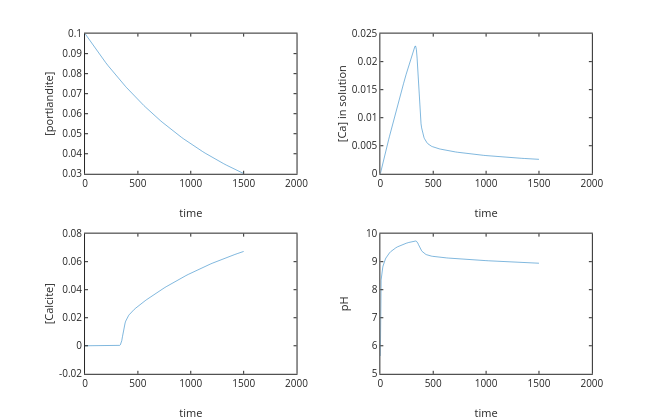

In [14]:
% call ODE solver

[t, C]=ode45(dCdtrate,[0 1500],[0.1 1e-9 0]); 

port=C(:,1); %portlandite left over
calcite=C(:,2); %Calcite formed
Ca=C(:,3); %Ca
pH=[]; % pH reset

for i=1:length(Ca)
    [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca(i),Kw,KH,Ka1,Ka2,PCO2);
    pH(i)=-log10(H);
end

subplot(221); plot(t,port); ylabel('[portlandite]'); xlabel('time')
subplot(222); plot(t,Ca); ylabel('[Ca] in solution'); xlabel('time')
subplot(223); plot(t,calcite); ylabel('[Calcite]'); xlabel('time')
subplot(224); plot(t,pH); ylabel('pH'); xlabel('time')
